<a id='top'></a>
# Community Discovery

In this notebook are introduced the main steps for the extraction and topological analysis of communities.



## Table of Contents

1. [Community Discovery Workflow](#workflow)
    1. [Dataframe for Direct and Undirect graph](#datarame)
    1. [Graph Creation](#graph)
    2. [Community Discovery algorithm(s) selection and configuration ](#model)
    3. [Clustering Evaluation (Fitness functions)](#fitness)
    4. [Clustering Evaluation (Comparison)](#comparison)
    5. [Community/Statistics Visualization](#visualization)
    6. [Qualitative evaluation](#qualitative)
    7. [Comparison  the   clustering methods ](#best)
    8. [Upload best community](#up)
    9. [Additional Figures and Tables](#fig)

import warnings
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
import cdlib
from cdlib import algorithms
from cdlib import ensemble as en
from cdlib import evaluation as evaluation
from cdlib import viz
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
def mesure_graph(DG):
    print('The Network DG has:\n Number of Nodes = ',DG.number_of_nodes(),'\n Number of Edges = ',DG.number_of_edges(),'\n')
    print('Average degree of "edges, links" = ',sum(dict(DG.degree()).values())/float(len(DG)))
    print('Is a Directed Network ?',DG.is_directed())

<a id="dataframe"></a>
### Dataframe for Direct and Undirect graph ([to top](#top))

### Data for Direct graph


In [3]:
df = pd.read_csv("scraping data/data/data_subreddit_direct.csv",index_col=0)

df1=df.copy()
#delete the columns 
columns2remove = ['date']
df.drop(columns2remove, inplace=True, axis=1)
df.head()


,parent,to,interactions,crossposts,weights
0,nature,environment,1746.0,1,7.465655
1,nature,EcoNewsNetwork,154.0,13,5.043425
2,nature,PublicLands,3.0,1,1.386294
3,nature,EndangeredSpecies,28.0,2,3.367296
4,nature,animalimpact,5.0,3,1.791759


### Directed Graph
The name of indirected Graph is "dfg"

### Data for Undirect graph

In [4]:
dfg = pd.read_csv("scraping data/data/data_subreddit_Undirect.csv",index_col=0)

dfg1=dfg.copy()
#delete the columns 
columns2remove = ['date']
dfg.drop(columns2remove, inplace=True, axis=1)

dfg.head()


,parent,to,interactions,crossposts,weights
0,nature,environment,1965.0,3,7.583756
1,nature,EcoNewsNetwork,292.0,18,5.680173
2,nature,PublicLands,3.0,1,1.386294
3,nature,EndangeredSpecies,28.0,2,3.367296
4,nature,animalimpact,5.0,3,1.791759


Normalize columns "crossposts" and "weights" of dfg

<a id='workflow'></a>
## Community Discovery Workflow ([to top](#top))

The standard workflow can be summarized as:
- Network Creation
- Community Discovery algorithm(s) selection and configuration
- Clustering(s) evaluation (Fitness functions)
- Clustering(s) evaluation (Comparisons)
- Community/Statistics Visualization

In this section we will observe how to templating such workflow applying two classic network clustering algorithms: Label Propagation and Leiden.
All analysis will be performed using ``CDlib``.

<a id="graph"></a>
### Graph object creation ([to top](#top))

As a first step we need to define the network topology that will be used as playground to study diffusive phenomena.

``CDlib`` natively supports both [``networkx``](https://networkx.github.io) and [``igraph``](https://igraph.org/python/) data structures.

In our examples, for the sake of simplicity, we will use ``networkx`` undirected graphs. 

### Undirected Graph
The name of indirected Graph is "g"

In [5]:
g=[]
g = nx.from_pandas_edgelist(dfg, source='parent', target='to',
                                     edge_attr=['crossposts', 'weights'],
                                     create_using=nx.Graph())
mesure_graph(g)

The Network DG has:
 Number of Nodes =  24819 
 Number of Edges =  104284 

Average degree of "edges, links" =  8.403561787340344
Is a Directed Network ? False


### Directed Graph
The name of indirected Graph is "dg"

In [6]:
dg=[]

dg = nx.from_pandas_edgelist(df, source='parent', target='to',
                                     edge_attr=['crossposts', 'weights'],
                                     create_using=nx.DiGraph)
mesure_graph(dg)

The Network DG has:
 Number of Nodes =  24819 
 Number of Edges =  107094 

Average degree of "edges, links" =  8.63000120875136
Is a Directed Network ? True


<a id="model"></a>
### Community Discovery algorithm(s) selection and configuration ([to top](#top))

After having defined the graph, we can select the algorithm(s) to partition it.

### Leiden
Community Discovery algorithm selection and configuration 

In [7]:
leiden_coms = algorithms.leiden(g,weights='crossposts')

All Community Discovery algorithms generate as result an object that implements a concrete instance of the ``Clustering`` datatype.
In particular, both Louvain and Label Propagation returns a ``NodeClustering`` object having the following propterties:

In [10]:
print('Clustering algorithm name is',leiden_coms.method_name,'\n') 
print('Clustering parameters',leiden_coms.method_parameters)


Clustering algorithm name is Leiden 

Clustering parameters {'initial_membership': None, 'weights': 'crossposts'}


In [11]:
leiden_clusters=leiden_coms.communities # Identified Clustering


In [12]:
print('Wehter the clustering is overlapping or not = ',leiden_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',leiden_coms.node_coverage,'\n') 

Wehter the clustering is overlapping or not =  False 

Percentage of nodes covered by the clustering =  1.0 



Moreover, ``Clustering`` object allow also for the generation of a JSON representation of the results

In [13]:
leiden_comunity_js=leiden_coms.to_json()

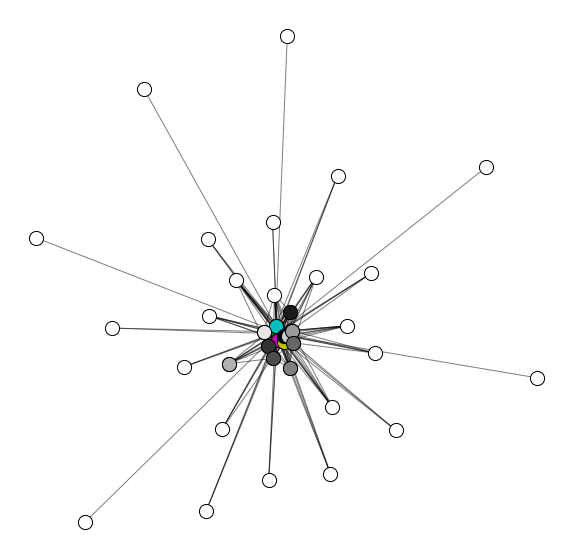

In [12]:
from cdlib import viz
viz.plot_community_graph(g, leiden_coms, figsize=(10, 10))

## Louvain
Community Discovery algorithm selection and configuration 

##### Optimal Search Louvain

In [ ]:
resolution = en.Parameter (name="resolution", start=0.1, end=1 , step =0.1 )
randomize = en.BoolParameter(name="randomize")
louvain_conf = [resolution, randomize]

# Optimal Search Louvain
[louv_comunity,louv_mod]= en.grid_search(graph=g , method= algorithms.louvain,
parameters =[resolution,randomize], quality_score = evaluation.erdos_renyi_modularity ,aggregate=max)
print(louv_comunity,louv_mod)

In [ ]:
print('Clustering algorithm name is',louv_comunity.method_name,'\n') 
print('Clustering parameters',louv_comunity.method_parameters)
louv_comunity

THE BEST PARAMETERS TO OPTIMIZE THE LOUVIAN METHOD ARE :<br>
resolution=0.8, not Random, and weight="crosspost", beacause the edge are weighted

Clustering algorithm name is Louvain 

Clustering parameters {'weight': 'crossposts', 'resolution': 0.8, 'randomize': False}
Identified Clustering with "Louvain", 

Wehter the clustering is overlapping or not =  False 

Percentage of nodes covered by the clustering =  1.0 



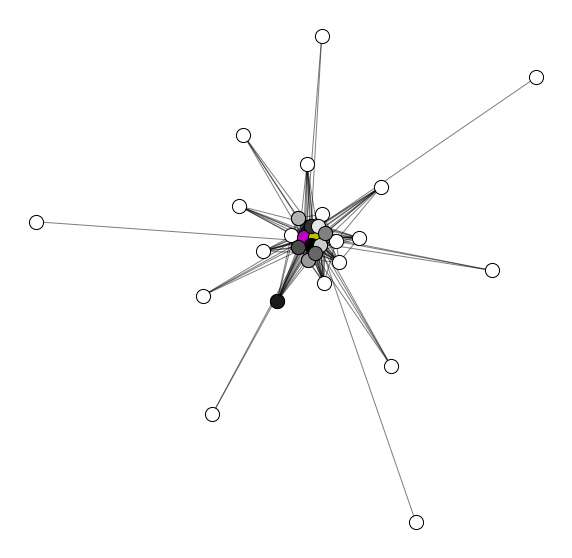

In [8]:
louv_coms = algorithms.louvain(g, weight='crossposts',resolution=0.8,randomize=False)

print('Clustering algorithm name is',louv_coms.method_name,'\n') 
print('Clustering parameters',louv_coms.method_parameters)
print('Identified Clustering with "Louvain", \n')

louv_clusters=louv_coms.communities 

print('Wehter the clustering is overlapping or not = ',louv_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',louv_coms.node_coverage,'\n') 

louv_comunity_js=louv_coms.to_json()

viz.plot_community_graph(g, louv_coms, figsize=(10, 10))

### Label Propagation
Community Discovery algorithm selection and configuration 

Clustering algorithm name is Label Propagation 

Clustering parameters {'': ''}
Identified Clustering with "Label Propagation", 

Wehter the clustering is overlapping or not =  False 

Percentage of nodes covered by the clustering =  1.0 



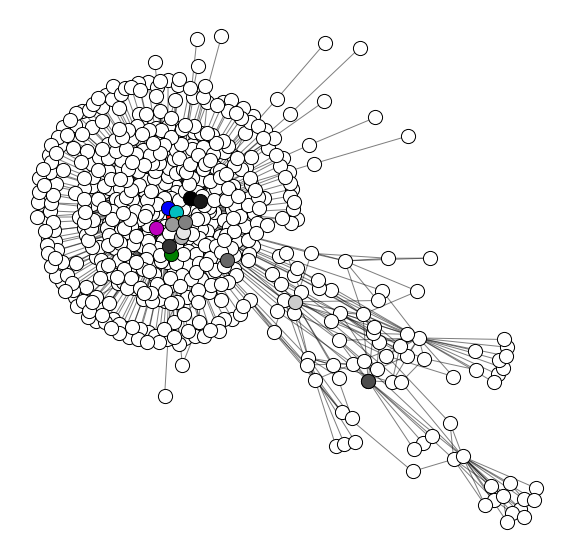

In [9]:
lp_coms = algorithms.label_propagation(g)

print('Clustering algorithm name is',lp_coms.method_name,'\n') 
print('Clustering parameters',lp_coms.method_parameters)
print('Identified Clustering with "Label Propagation", \n')

lp_clusters=lp_coms.communities 

print('Wehter the clustering is overlapping or not = ',lp_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',lp_coms.node_coverage,'\n') 

lp_comunity_js=lp_coms.to_json()

viz.plot_community_graph(g, lp_coms, figsize=(10, 10))

### Demon

##### Optimal Search Demon

In [ ]:
eps = en.Parameter(name="epsilon", start=0.1 , end=1 , step =0.1 )
min_coms=en.Parameter(name="min_com_size", start=3, end=9, step=3)

demon_conf = [eps]

# Optimal Search Louvain
[demon_comunity,demon_scoring]= en.grid_search(graph=g , method= algorithms.demon,
parameters =[eps,min_coms], quality_score = evaluation.erdos_renyi_modularity ,aggregate=max)


In [ ]:
print(demon_comunity,demon_scoring)
print('Clustering algorithm name is',demon_comunity.method_name,'\n') 
print('Clustering parameters',demon_comunity.method_parameters)
louv_comunity

The best PARAMETERS TO OPTIMIZE THE DEMON METHOD ARE:<br>
 min_com_size= 3 and epsilon=0.9  

In [10]:
demon_coms = algorithms.demon(g, min_com_size=3,epsilon=0.9)

print('Clustering algorithm name is',demon_coms.method_name,'\n') 
print('Clustering parameters',demon_coms.method_parameters)
print('Identified Clustering with "Label Propagation", \n')

demon_clusters=demon_coms.communities 

print('Wehter the clustering is overlapping or not = ',demon_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',demon_coms.node_coverage,'\n') 

#demon_comunity_js=demon_coms.to_json()

#viz.plot_community_graph(g, demon_coms, figsize=(10, 10))

Clustering algorithm name is DEMON 

Clustering parameters {'epsilon': 0.9, 'min_com_size': 3}
Identified Clustering with "Label Propagation", 

Wehter the clustering is overlapping or not =  True 

Percentage of nodes covered by the clustering =  0.38575285063862363 



### Infomap
Community Discovery algorithm selection and configuration 

Clustering algorithm name is Infomap 

Clustering parameters {'': ''}
Identified Clustering with "infomap": 

Wehter the clustering is overlapping or not =  False 

Percentage of nodes covered by the clustering =  1.0 



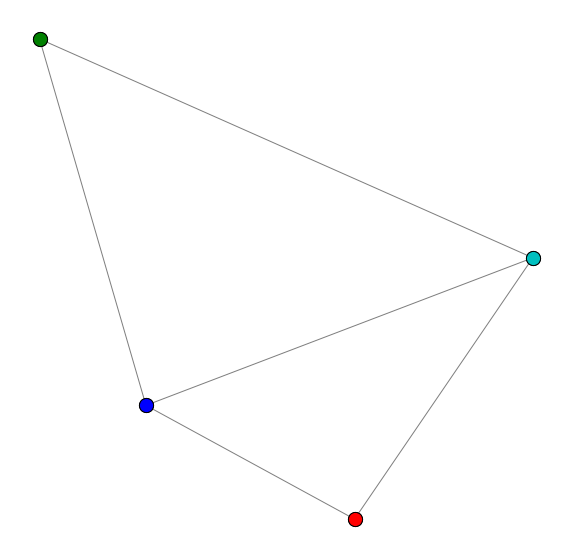

In [11]:
info_coms = algorithms.infomap(g)

print('Clustering algorithm name is',info_coms.method_name,'\n') 
print('Clustering parameters',info_coms.method_parameters)

info_clusters=info_coms.communities 
print('Identified Clustering with "infomap": \n')
print('Wehter the clustering is overlapping or not = ',info_coms.overlap,'\n') 
print('Percentage of nodes covered by the clustering = ',info_coms.node_coverage,'\n') 

info_comunity_js=info_coms.to_json()

viz.plot_community_graph(g, info_coms, figsize=(10, 10))

<a id="fitness"></a>
### Clustering Evaluation (Fitness functions) ([to top](#top))

After having obtained a network clustering we can compute several indexes upon it. 

For a same index it is possible to obtain a synthetic representation of its min/max/mean/std values

### Leiden
Clustering Evaluation (Fitness functions)

In [21]:
leiden_fit=leiden_coms.average_internal_degree()
print('Internal degree:\n', leiden_fit)


Internal degree:
 FitnessResult(min=1.0, max=8.121065375302663, score=3.0128480097913943, std=1.5523114584882667)


as well as its communitiy-wise value

In [22]:
Leiden_in_degree=leiden_coms.average_internal_degree(summary=False)
print('Average Internal grade comunities with Leiden: \n',Leiden_in_degree)


Average Internal grade comunities with Leiden: 
 [5.383232362712527, 5.876210032267527, 4.174812700677845, 5.074915824915825, 3.4177949709864603, 5.190891472868217, 5.949914627205464, 8.121065375302663, 3.3316708229426433, 4.291729323308271, 3.2135728542914173, 2.4448979591836735, 2.6610169491525424, 3.312320916905444, 4.257731958762887, 2.502923976608187, 2.537313432835821, 2.054054054054054, 1.9428571428571428, 2.4545454545454546, 1.8823529411764706, 2.75, 1.8666666666666667, 2.4, 2.4285714285714284, 3.857142857142857, 1.8333333333333333, 2.0, 2.0, 1.75, 4.857142857142857, 1.7142857142857142, 1.7142857142857142, 1.6666666666666667, 1.6666666666666667, 2.3333333333333335, 1.6, 1.5, 1.5, 1.0]


Fitness scores can also be instantiated at library level

For the complete list of implemented fitness functions, refer to the online [documentation](https://cdlib.readthedocs.io/en/latest/reference/evaluation.html).

### Louvain
Clustering Evaluation (Fitness functions)

In [226]:
louv_fit=louv_coms.average_internal_degree()
print('Internal degree:\n',louv_fit)
louv_in_degree=louv_coms.average_internal_degree(summary=False)
print('\n Average Internal grade comunities with Louvain: \n\n',louv_in_degree)

Internal degree:
 FitnessResult(min=1.5, max=8.028144239226034, score=3.14899238103632, std=1.5404668672212345)

 Average Internal grade comunities with Louvain: 

 [4.89753839680202, 4.056728232189974, 5.699231613611416, 5.776424532405394, 5.218157778757162, 6.046827794561934, 3.9270186335403725, 8.028144239226034, 3.2579075425790753, 3.355525965379494, 2.3392226148409896, 2.6199261992619927, 2.4250474383301706, 4.177865612648222, 2.4421906693711968, 2.6136865342163356, 3.7630662020905925, 2.3636363636363638, 2.4901960784313726, 4.680555555555555, 2.1769911504424777, 2.3733333333333335, 2.210526315789474, 2.2448979591836733, 1.9285714285714286, 2.75, 1.8666666666666667, 2.4, 1.8181818181818181, 2.0, 2.0, 1.6666666666666667, 1.6, 1.5, 1.5]


### Label Propagation
Clustering Evaluation (Fitness functions)

In [24]:
lp_fit=lp_coms.average_internal_degree()
print('Internal degree:\n',lp_fit)
lp_in_degree=lp_coms.average_internal_degree(summary=False)
print('\n Average Internal grade comunities with Label Propagation \n',lp_in_degree)

Internal degree:
 FitnessResult(min=1.0, max=9.242867593269935, score=1.4314826670505014, std=0.6700390659451055)

 Average Internal grade comunities with Label Propagation 
 [7.762101498427576, 9.242867593269935, 2.6545454545454548, 5.466666666666667, 2.0, 1.9615384615384615, 2.0, 1.9583333333333333, 1.9583333333333333, 2.1666666666666665, 1.9555555555555555, 1.9523809523809523, 2.0526315789473686, 3.1666666666666665, 1.9375, 1.9375, 2.129032258064516, 2.7096774193548385, 2.2222222222222223, 2.6666666666666665, 1.9230769230769231, 2.6315789473684212, 1.894736842105263, 1.8888888888888888, 1.8888888888888888, 4.222222222222222, 1.8888888888888888, 1.875, 2.125, 1.875, 1.875, 2.875, 1.8666666666666667, 2.2857142857142856, 1.8571428571428572, 1.8571428571428572, 1.8571428571428572, 1.8571428571428572, 2.7142857142857144, 3.076923076923077, 1.8461538461538463, 1.8333333333333333, 1.8333333333333333, 3.5, 1.8333333333333333, 2.8333333333333335, 3.3333333333333335, 1.8181818181818181, 1.818

### Infomap

Clustering Evaluation (Fitness functions)


In [25]:
info_fit=info_coms.average_internal_degree()
print('Internal degree:\n',info_fit)

print('Average Internal grade comunities with Infomap \n')
info_in_degree=info_coms.average_internal_degree(summary=False)
info_in_degree

Internal degree:
 FitnessResult(min=2.3883495145631066, max=8.512005910602143, score=3.934055224295468, std=2.643171495458629)
Average Internal grade comunities with Infomap 



[8.512005910602143, 2.443708609271523, 2.3883495145631066, 2.392156862745098]

### Demon

In [26]:
demon_fit=demon_coms.average_internal_degree()
print('Internal degree:\n',louv_fit)
demon_in_degree=demon_coms.average_internal_degree(summary=False)
print('\n Average Internal grade comunities with Louvain: \n\n',demon_in_degree)

Internal degree:
 FitnessResult(min=1.5, max=8.028144239226034, score=3.14899238103632, std=1.5404668672212345)

 Average Internal grade comunities with Louvain: 

 [20.179240969364425, 21.477496120020692, 27.8986013986014, 25.371323529411764, 18.845105328376704, 18.994142259414225, 20.299551569506725, 18.90719696969697, 17.531475748194016, 19.15846994535519, 16.556906077348067, 17.82305005820722, 23.61868686868687, 14.596306068601583, 13.579375848032564, 25.0873786407767, 18.044510385756677, 16.72826086956522, 15.617810760667904, 15.161048689138577, 15.712665406427222, 33.67128712871287, 14.937119675456389, 35.62061855670103, 15.753138075313808, 18.817021276595746, 20.57391304347826, 24.816593886462883, 9.345537757437071, 12.871794871794872, 24.40776699029126, 14.525547445255475, 8.22549019607843, 27.201970443349754, 8.110552763819095, 17.507614213197968, 21.421319796954315, 29.12793733681462, 10.445682451253482, 23.20343839541547, 30.487951807228917, 15.447852760736197, 9.92569659442

<a id="comparison"></a>
### Clustering Evaluation (Comparison) ([to top](#top))

When multiple clustering have been computed on a same network it is useful to measure their resemblance.

``CDlib`` allows to do so by exposing several clustering resemblance scores, each one of them tailored to support specific kind of network clusterings (crisp/partition, complete/partial node coverage).

As for the fitness functions, resemblance scores can be instantiated at the community level as well as at the library level.
The scores is also a value of similarity between

In [27]:

evaluation.normalized_mutual_information(leiden_coms,louv_coms)

MatchingResult(score=0.6740268676449048, std=None)

In [28]:
evaluation.normalized_mutual_information(leiden_coms, lp_coms)


MatchingResult(score=0.3812651476962751, std=None)

In [29]:
evaluation.normalized_mutual_information(louv_coms,info_coms)

MatchingResult(score=0.06087669674006197, std=None)

In [30]:
evaluation.normalized_mutual_information(louv_coms,lp_coms)

MatchingResult(score=0.3762466467786809, std=None)

<a id="visualization"></a>
### Community/Statistics Visualization ([to top](#top))

``CDlib`` allows to generate two families of predefined plots:
- network/community visualizations
- community fitness/comparison visualizations

### Graph visualization

One way to visualize the communities identified on a graph is by coloring graph nodes accordingly.<br>
Every node is a community with different internal degree


Figure 1 Communities with Leiden 

Figure 2 Communities with Louvain 

Figure 3 Communities with Label Propagation 

Figure 4 Communities with Infomap 



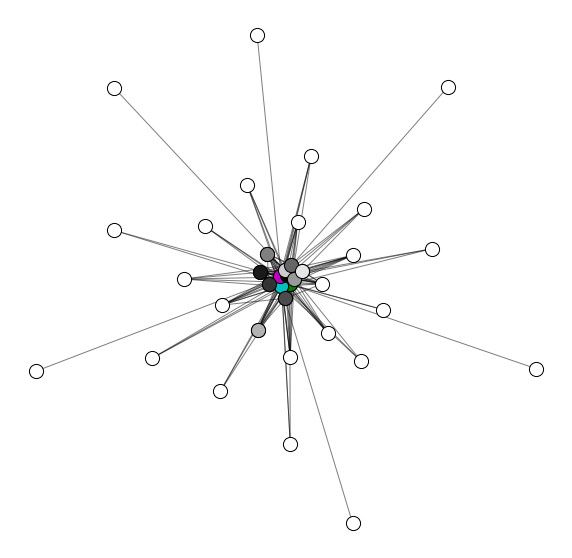

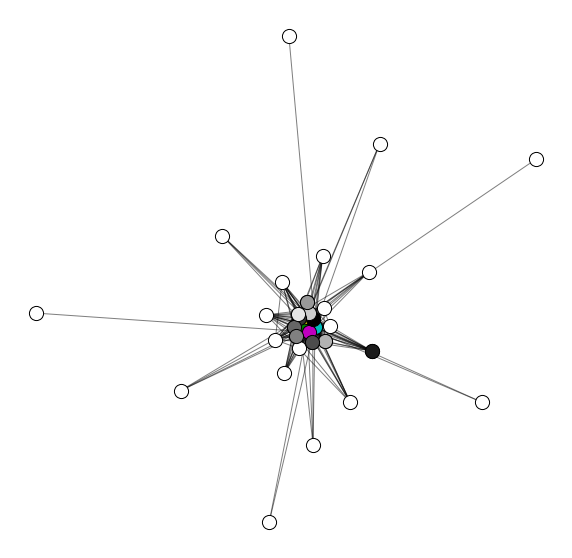

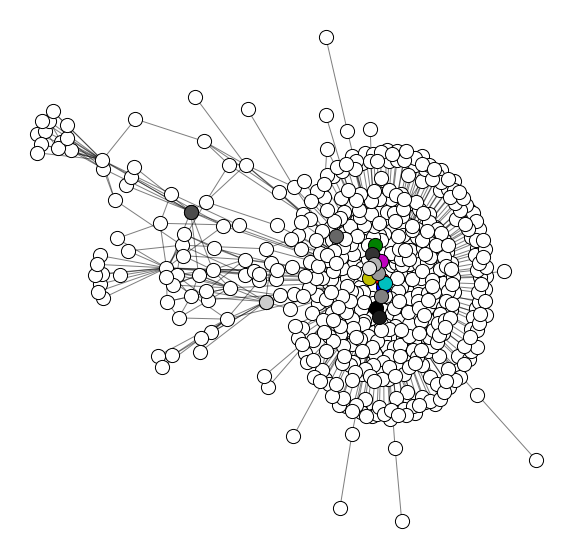

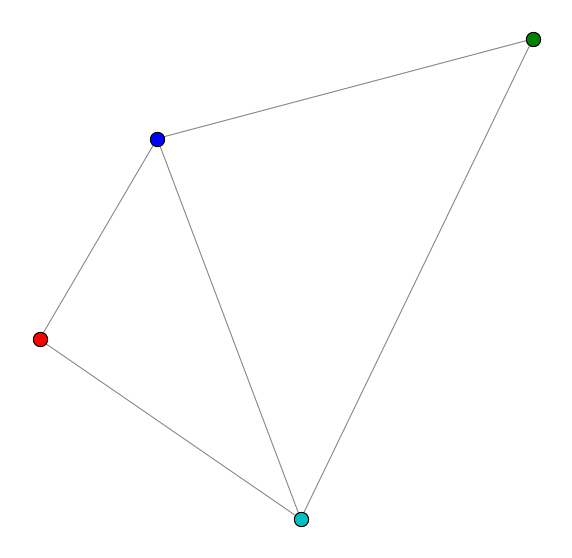

In [71]:
coms=[leiden_coms,louv_coms,lp_coms,info_coms]

for i in range(len(coms)):
    print('Figure',i+1,'Communities with',coms[i].method_name ,'\n')
    viz.plot_community_graph(g,coms[i], figsize=(10, 10))
     

### Plot the communities  top 10  

Figure 1 Communities with Leiden 

Figure 2 Communities with Louvain 

Figure 3 Communities with Label Propagation 

Figure 4 Communities with DEMON 

Figure 5 Communities with Infomap 



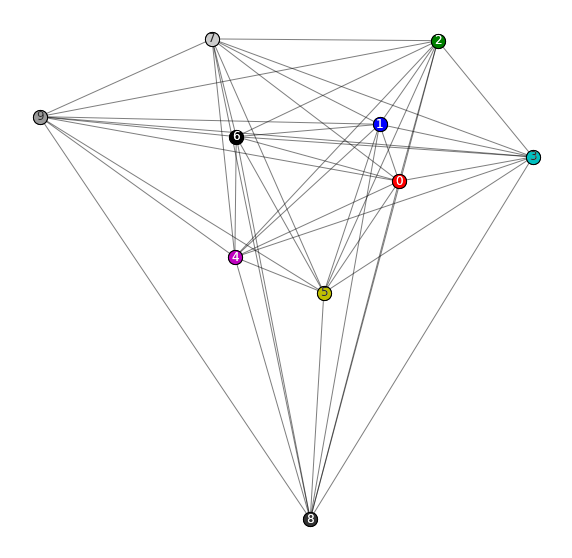

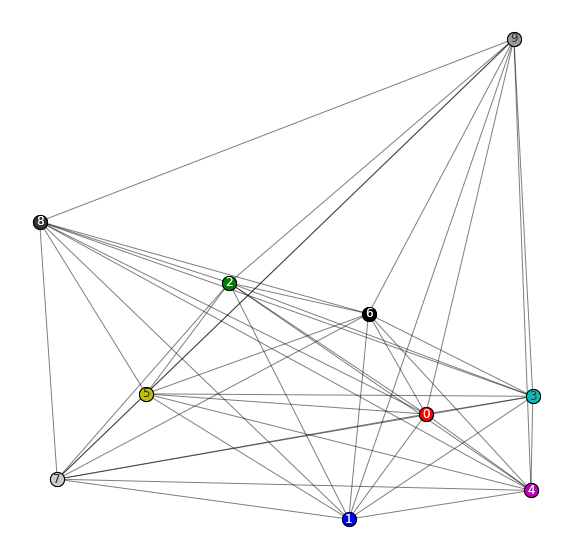

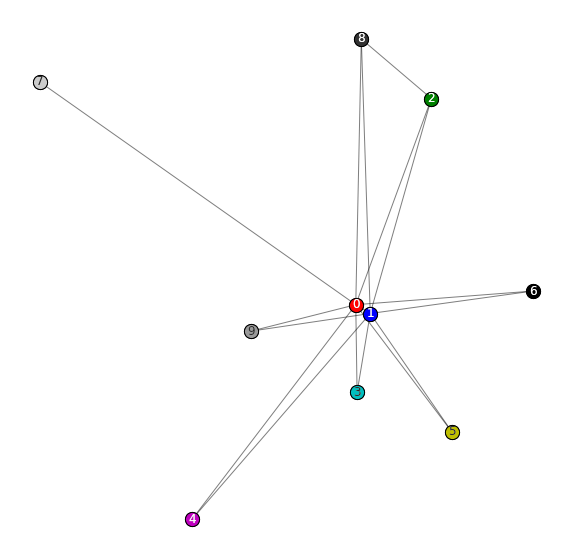

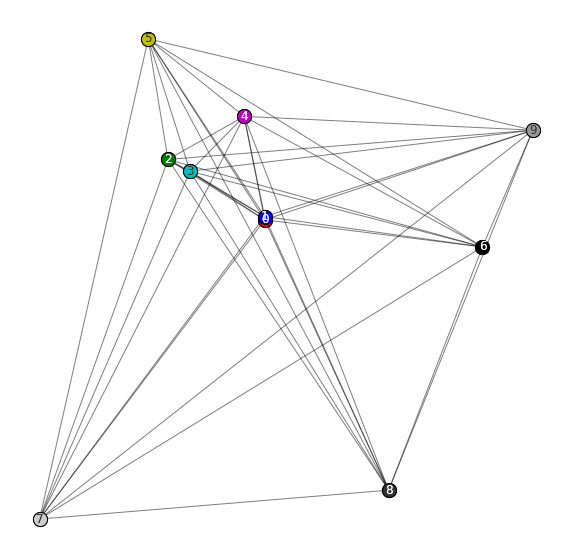

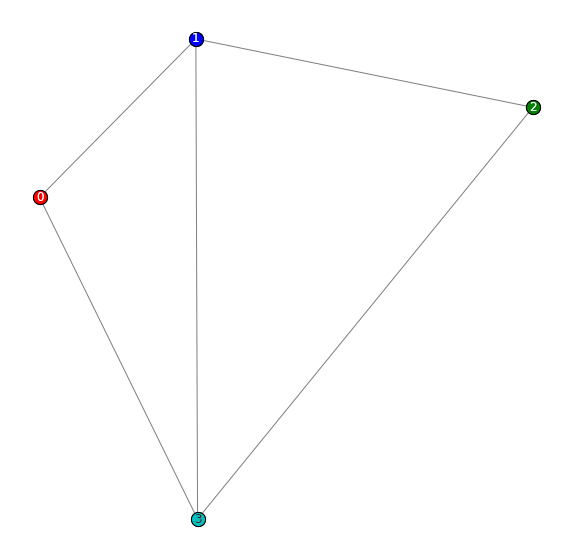

In [33]:
coms=[leiden_coms,louv_coms,lp_coms,demon_coms,info_coms]

for i in range(len(coms)):
    
    print('Figure',i+1,'Communities with',coms[i].method_name ,'\n')
    viz.plot_community_graph(g,coms[i], figsize=(10, 10),
                        plot_labels=True,top_k=10)


Such strategy is feasible when the network is small enogh. In case of medium size graphs an alternative is collapsing all community nodes into a single met-node and visualize the resulting community graph:

### Community fitness/comparison visualization

Given one (or more) clustering it could be useful to visualize how a given fitness function distributes over the communities.

A nice way to do so is by using violin plots.

In [35]:
from cdlib import viz

#### Compare the Violinplots

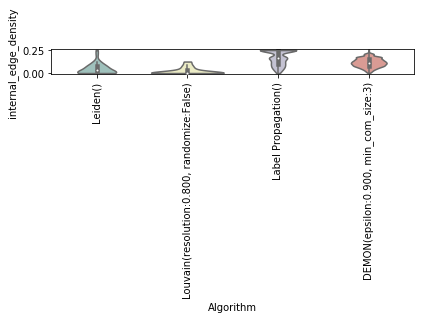

In [19]:

viz.plot_com_stat([leiden_coms,louv_coms, lp_coms,demon_coms],evaluation.internal_edge_density)


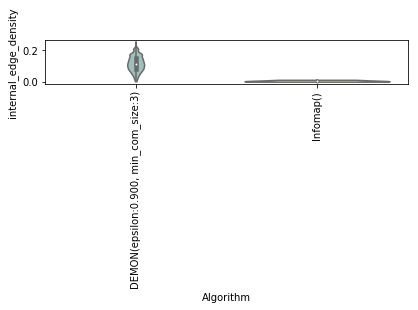

In [266]:
viz.plot_com_stat([demon_coms,info_coms],evaluation.internal_edge_density)
plt.show()


#### Violinplot with all methods

dpi=default: 100.0 , figsize=(default: [6.4, 4.8])
for the figure i have multipkied 

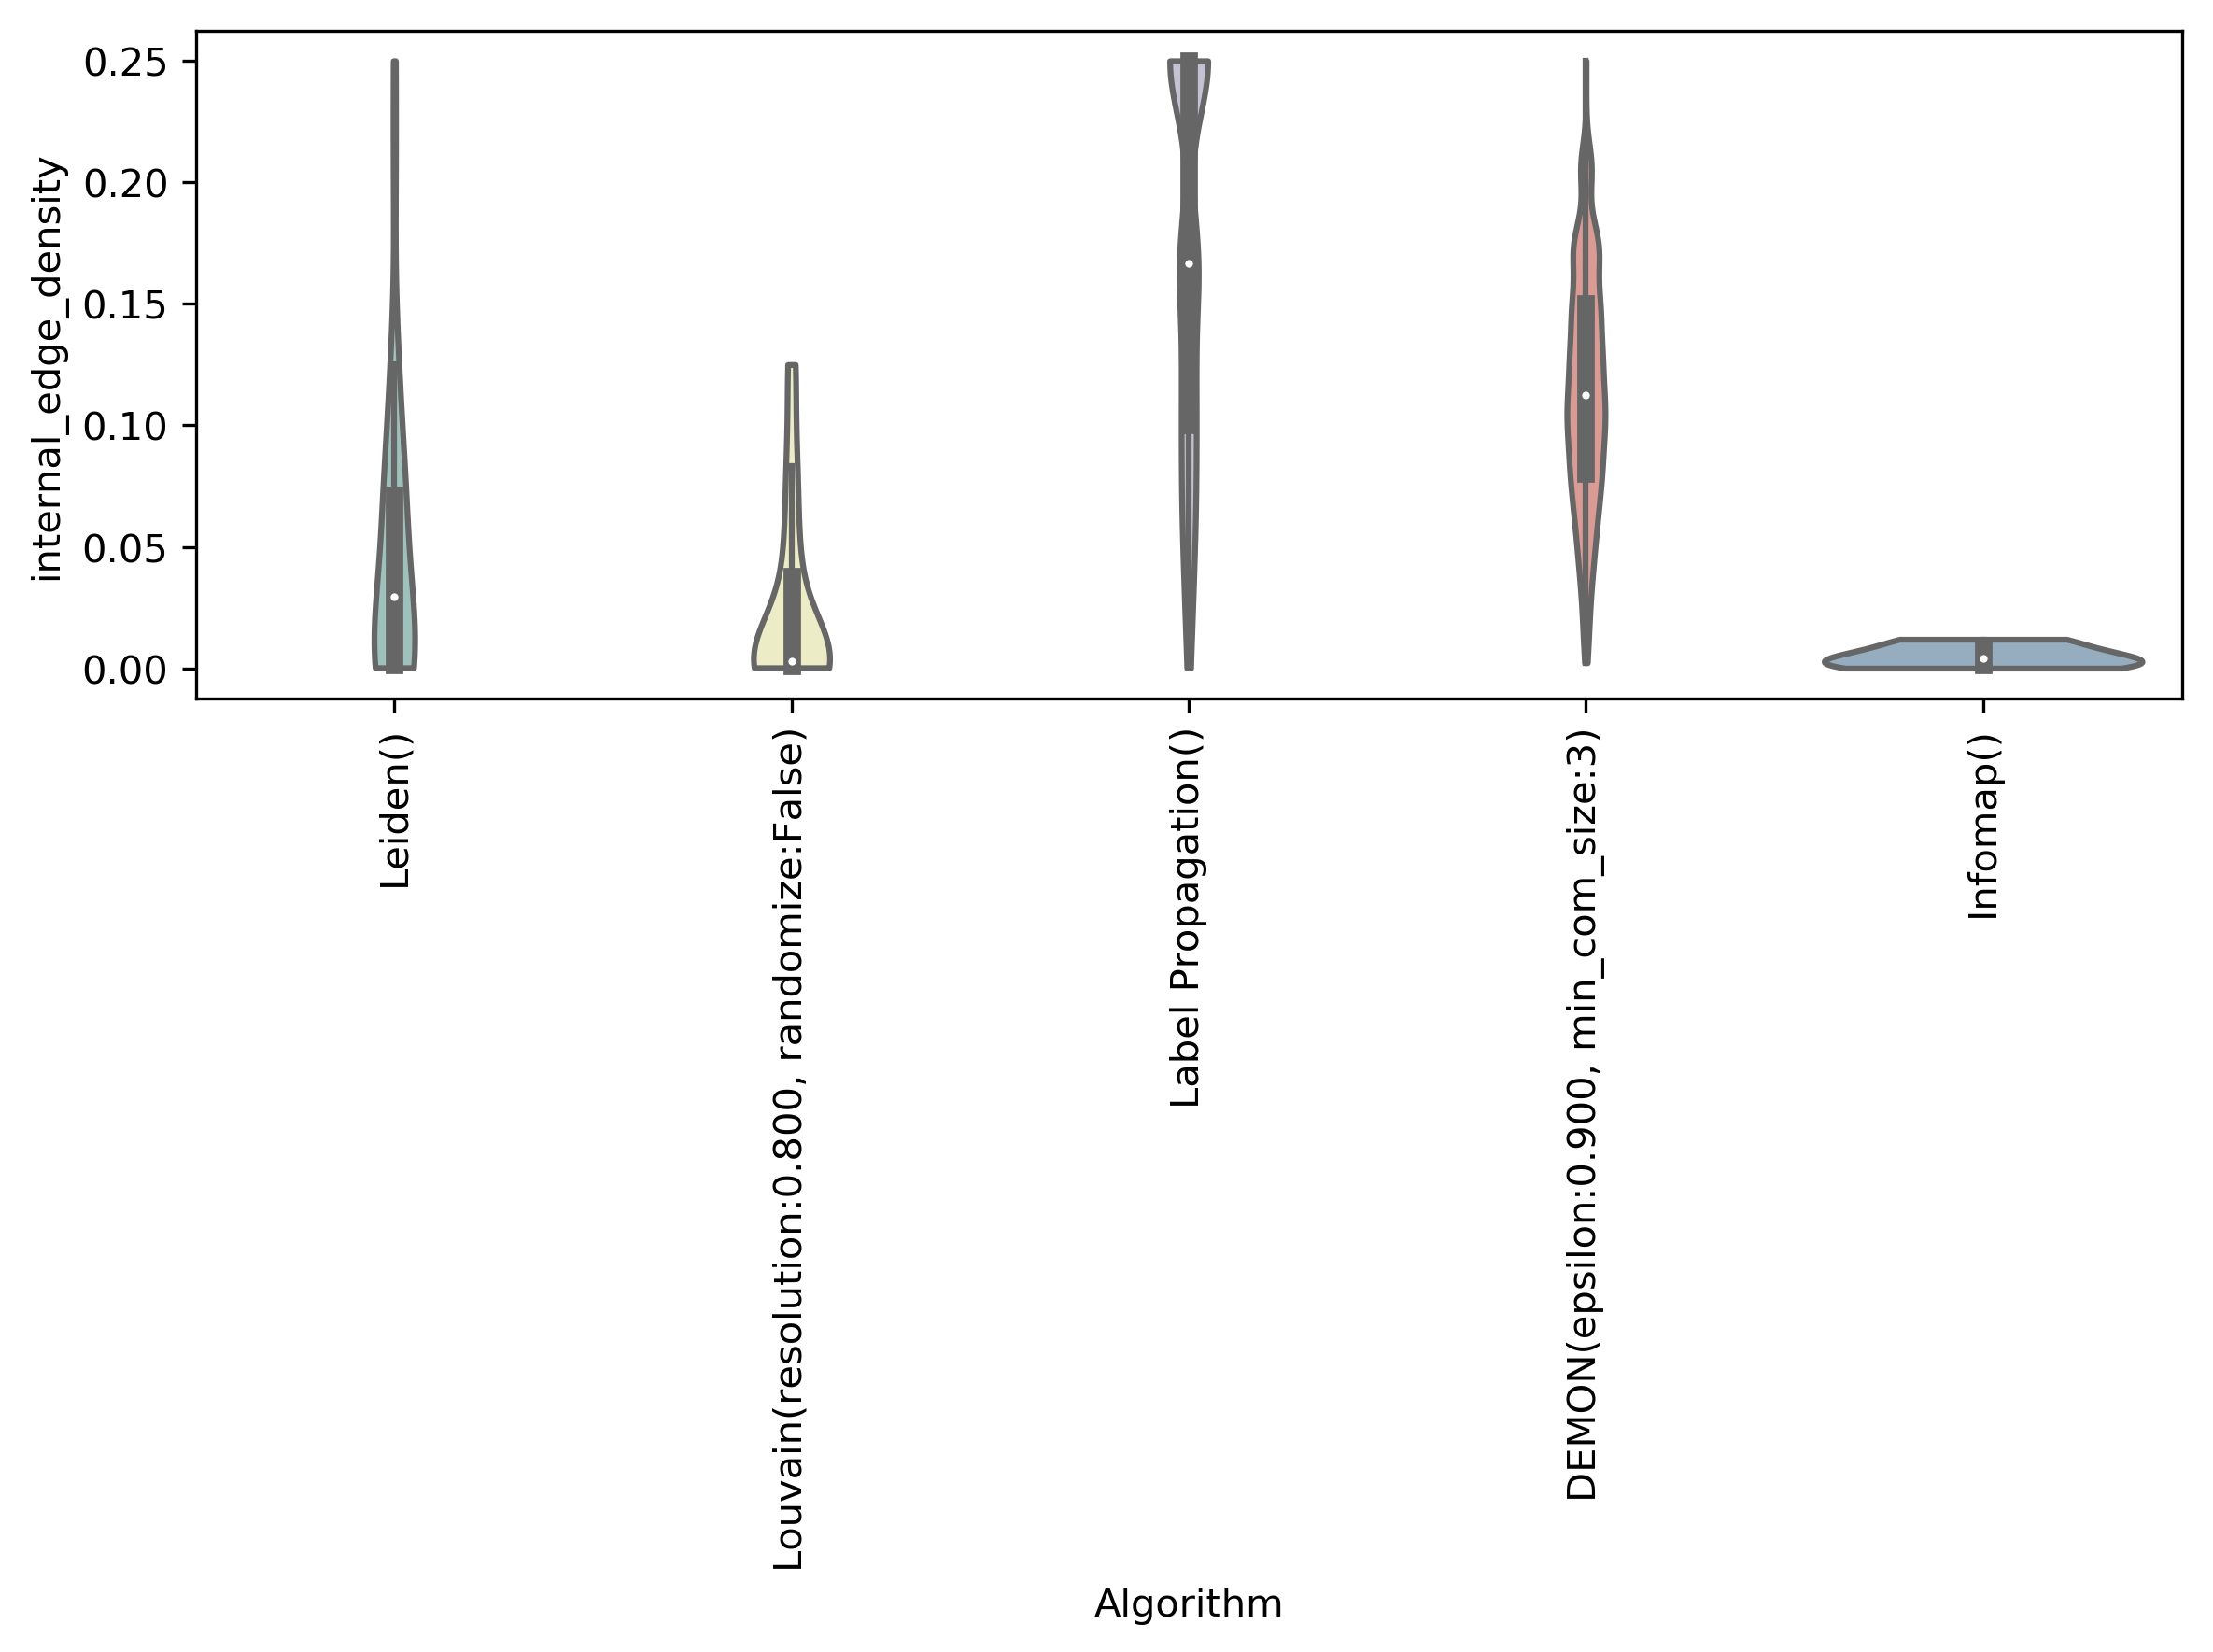

In [53]:
plt.figure(figsize=[8,6],dpi=300)
viz.plot_com_stat([leiden_coms,louv_coms,lp_coms,demon_coms,info_coms],evaluation.internal_edge_density)


Another simple visualization type that allows getting a few insights on community characteristics is the scatter plot.

We can easily pair-wise compare fitness functions for one or more clustering as follows:

#### Compare Internal edge density vs Size
In the first figure between Leiden, Louvain, Label propagations methods.<br>
In the second figure between Demon and Infomap.<br>

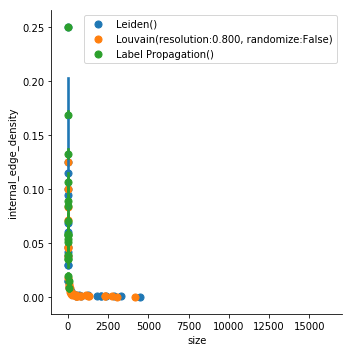

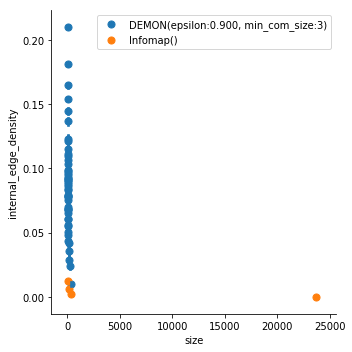

In [38]:
viz.plot_com_properties_relation([leiden_coms,louv_coms, lp_coms], evaluation.size, evaluation.internal_edge_density)
viz.plot_com_properties_relation([demon_coms,info_coms], evaluation.size, evaluation.internal_edge_density)

#### Compare Average degree vs Size
In the first figure between Leiden, Louvain, Label propagations methods.<br>
In the second figure between Demon and Infomap.<br>

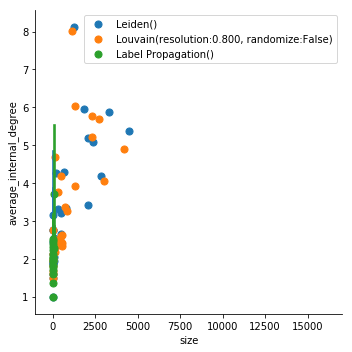

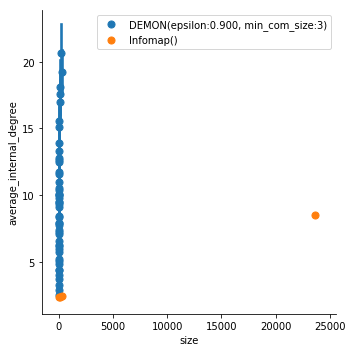

In [39]:
viz.plot_com_properties_relation([leiden_coms,louv_coms, lp_coms], evaluation.size, evaluation.average_internal_degree)

viz.plot_com_properties_relation([demon_coms,info_coms], evaluation.size, evaluation.average_internal_degree)

#### Comp  Conductance Vs. Size
In the first figure between Leiden, Louvain, Label propagations methods.<br>
In the second figure between Demon and Infomap.<br>

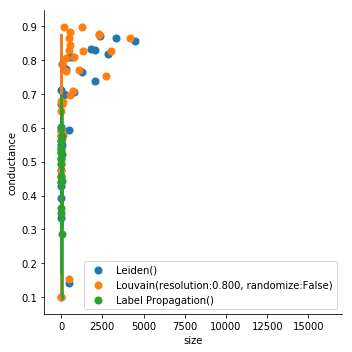

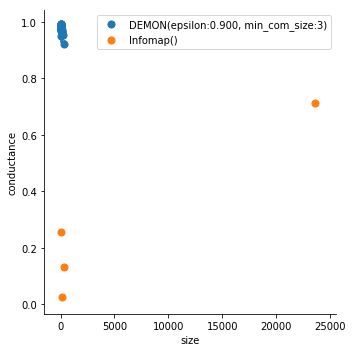

In [40]:
viz.plot_com_properties_relation([leiden_coms,louv_coms, lp_coms], evaluation.size, evaluation.conductance)

viz.plot_com_properties_relation([demon_coms,info_coms], evaluation.size, evaluation.conductance)

#### Compare Conductance  Vs. Internal density
In the first figure between Leiden, Louvain, Label propagations methods.<br>
In the second figure between Demon and Infomap.<br>

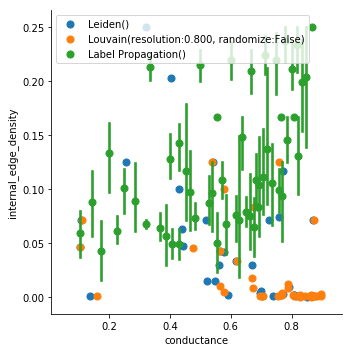

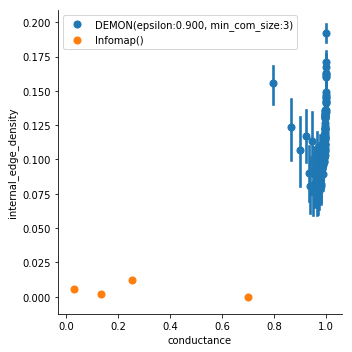

In [41]:
viz.plot_com_properties_relation([leiden_coms,louv_coms, lp_coms], evaluation.conductance, evaluation.internal_edge_density)

viz.plot_com_properties_relation([demon_coms,info_coms], evaluation.conductance , evaluation.internal_edge_density)

#### Compare Average degree  Vs. Internal density
In the first figure between Leiden, Louvain, Label propagations methods.<br>
In the second figure between Demon and Infomap.<br>

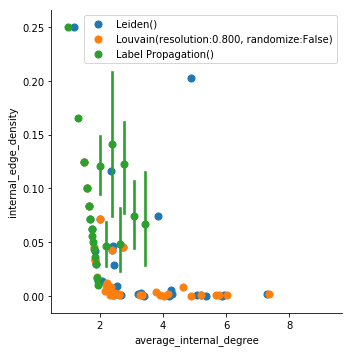

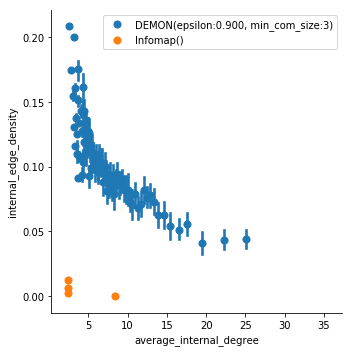

In [42]:
viz.plot_com_properties_relation([leiden_coms,louv_coms, lp_coms], evaluation.average_internal_degree, evaluation.internal_edge_density)

viz.plot_com_properties_relation([demon_coms,info_coms], evaluation.average_internal_degree , evaluation.internal_edge_density)

<a id="qualitative"></a>
### Qualitative evaluation ([to top](#top))

Another way to validate a clustering is to analyse the purity of each community w.r.t. an external attribute.

In our example, let's consider the Houses of GoT characters: what's the CD approach among the tested ones that allows to identify more "homogeneous" clusters?

##### Erdos-Renyi Modularity

In [43]:
# Modularity evaluation

leiden_mod1=[]
louv_mod1=[]
lp_mod1=[]
demon_mod1=[]
info_mod1=[]

leiden_mod1=evaluation.erdos_renyi_modularity(g,leiden_coms, summary=False)
louv_mod1=evaluation.erdos_renyi_modularity(g,louv_coms)
lp_mod1=evaluation.erdos_renyi_modularity(g,lp_coms)
demon_mod1=evaluation.erdos_renyi_modularity(g,demon_coms)
info_mod1=evaluation.erdos_renyi_modularity(g,info_coms)
print('Leiden Erdos-Renyi Modularity\n',leiden_mod1,'\n')
print('Louv Erdos-Renyi Modularity\n',louv_mod1,'\n')
print('Label Propagation Erdos-Renyi Modularity\n',lp_mod1,'\n')
print('Demon Erdos-Renyi Modularity\n',demon_mod1, '\n')
print('Infomap Erdos-Renyi Modularity\n',info_mod1, '\n')


Leiden Erdos-Renyi Modularity
 FitnessResult(min=None, max=None, score=-0.015323176079126234, std=None) 

Louv Erdos-Renyi Modularity
 FitnessResult(min=None, max=None, score=-0.009431524130099456, std=None) 

Label Propagation Erdos-Renyi Modularity
 FitnessResult(min=None, max=None, score=-0.20195227718774364, std=None) 

Demon Erdos-Renyi Modularity
 FitnessResult(min=None, max=None, score=0.6290154227060607, std=None) 

Infomap Erdos-Renyi Modularity
 FitnessResult(min=None, max=None, score=-0.4698227637112978, std=None) 



#### Newman Girvan Modularity 

In [44]:
leiden_mod2=[]
louv_mod2=[]
lp_mod2=[]
demon_mod2=[]
info_mod2=[]

leiden_mod2=evaluation.newman_girvan_modularity(g,leiden_coms, summary=False)
louv_mod2=evaluation.newman_girvan_modularity(g,louv_coms)
lp_mod2=evaluation.newman_girvan_modularity(g,lp_coms)
demon_mod2=evaluation.newman_girvan_modularity(g,demon_coms)
info_mod2=evaluation.modularity_density(g,info_coms)
print('Leiden Newman Girvan Modularity\n',leiden_mod2,'\n')
print('Louv Newman Girvan Modularity\n',louv_mod2,'\n')
print('Label Propagation Newman Girvan Modularity\n',lp_mod2,'\n')
print('Demon Newman Girvan Modularity\n',demon_mod2, '\n')
print('Infomap Newman Girvan Modularity\n',info_mod2, '\n')


Leiden Newman Girvan Modularity
 FitnessResult(min=None, max=None, score=0.0348441057899245, std=None) 

Louv Newman Girvan Modularity
 FitnessResult(min=None, max=None, score=0.03442962971003583, std=None) 

Label Propagation Newman Girvan Modularity
 FitnessResult(min=None, max=None, score=0.022079597368655394, std=None) 

Demon Newman Girvan Modularity
 FitnessResult(min=None, max=None, score=0.0016837534224826538, std=None) 

Infomap Newman Girvan Modularity
 FitnessResult(min=None, max=None, score=-6.789768089852286, std=None) 



#### The Modularity density
we calculated the "Modularity density" with the resolution parameter = 1<br>


In [57]:
leiden_mod3=[]
louv_mod3=[]
lp_mod3=[]
demon_mod3=[]
info_mod3=[]

leiden_mod3=evaluation.modularity_density(g,leiden_coms,lmbd=1)
louv_mod3=evaluation.modularity_density(g,louv_coms,lmbd=1)
lp_mod3=evaluation.modularity_density(g,lp_coms,lmbd=1)
demon_mod3=evaluation.modularity_density(g,demon_coms,lmbd=1)
info_mod3=evaluation.modularity_density(g,info_coms,lmbd=1)
print('Leiden Modularity density\n',leiden_mod3,'\n')
print('Louv Modularity density\n',louv_mod3,'\n')
print('Label Propagation Modularity density\n',lp_mod3,'\n')
print('Demon Modularity density\n',demon_mod3, '\n')
print('Infomap Modularity density\n',info_mod3, '\n')

Leiden Modularity density
 FitnessResult(min=None, max=None, score=241.02784078331146, std=None) 

Louv Modularity density
 FitnessResult(min=None, max=None, score=220.42946667254242, std=None) 

Label Propagation Modularity density
 FitnessResult(min=None, max=None, score=1663.3828591126864, std=None) 

Demon Modularity density
 FitnessResult(min=None, max=None, score=54216.602089832435, std=None) 

Infomap Modularity density
 FitnessResult(min=None, max=None, score=31.47244179436374, std=None) 



#### Z-modularity 

In [62]:

leiden_mod4=[]
louv_mod4=[]
lp_mod4=[]
demon_mod4=[]
info_mod4=[]

leiden_mod4=evaluation.z_modularity(g,leiden_coms, summary=False)
louv_mod4=evaluation.z_modularity(g,louv_coms)
lp_mod4=evaluation.z_modularity(g,lp_coms)
demon_mod4=evaluation.z_modularity(g,demon_coms)
info_mod4=evaluation.z_modularity(g,info_coms)
print('Leiden Z Modularity\n',leiden_mod4,'\n')
print('Louv Z Modularity\n',louv_mod4,'\n')
print('Label Propagation Z Modularity\n',lp_mod4,'\n')
print('Demon Z Modularity\n',demon_mod4, '\n')
print('Infomap Z Modularity\n',info_mod4, '\n')

Leiden Z Modularity
 FitnessResult(min=None, max=None, score=0.3312671325074002, std=None) 

Louv Z Modularity
 FitnessResult(min=None, max=None, score=0.3607530154619475, std=None) 

Label Propagation Z Modularity
 FitnessResult(min=None, max=None, score=0.10487450086869947, std=None) 

Demon Z Modularity
 FitnessResult(min=None, max=None, score=-0.42052442363224857, std=None) 

Infomap Z Modularity
 FitnessResult(min=None, max=None, score=0.015180091858014904, std=None) 



#### Conduttance evaluation

In [47]:
# Conduttance evaluation

leiden_cond=[]
louv_cond=[]
lp_cond=[]
demon_cond=[]
info_cond=[]
leiden_cond=evaluation.conductance(g,leiden_coms)# Modularity evaluation
louv_cond=evaluation.conductance(g,louv_coms)
lp_cond=evaluation.conductance(g,lp_coms)
demon_cond=evaluation.conductance(g,demon_coms)
info_cond=evaluation.conductance(g,info_coms)
print('Leiden Conductance\n',leiden_cond,'\n')
print('Louvain Conductance\n',louv_cond,'\n')
print('Label Propagation Conductance Mod\n',lp_cond,'\n')
print('Demon Conductance\n',demon_cond, '\n')
print('Infomap Conductance\n',info_cond, '\n')



Leiden Conductance
 FitnessResult(min=0.10204081632653061, max=0.873015873015873, score=0.6176083418497511, std=0.21040164047378682) 

Louvain Conductance
 FitnessResult(min=0.10204081632653061, max=0.8966008548748219, score=0.694366466768416, std=0.20930490342092717) 

Label Propagation Conductance Mod
 FitnessResult(min=0.06382978723404255, max=0.9130434782608695, score=0.5326154284971371, std=0.19245602053593444) 

Demon Conductance
 FitnessResult(min=0.2857142857142857, max=0.9993567477164544, score=0.9804608909637383, std=0.04037667352871278) 

Infomap Conductance
 FitnessResult(min=0.02766798418972332, max=0.7141285648117515, score=0.28241470396485935, std=0.2620404371566043) 



#### Scaled density 

In [48]:
leiden_den=[]
louv_den=[]
lp_den=[]
demon_den=[]
info_den=[]

leiden_den=evaluation.scaled_density(g,leiden_coms)# Modularity evaluation
louv_den=evaluation.scaled_density(g,louv_coms)
lp_den=evaluation.scaled_density(g,lp_coms)
demon_den=evaluation.scaled_density(g,demon_coms)
info_den=evaluation.scaled_density(g,info_coms)
print('Leiden Scaled Density\n',leiden_den,'\n')
print('Louvain Scaled Density\n',louv_den,'\n')
print('Label Scaled Density\n',lp_den,'\n')
print('Demon Scaled Density\n',demon_den, '\n')
print('Infomap Scaled Density\n',info_den,'\n')

Leiden Scaled Density
 FitnessResult(min=0.4284641802690515, max=407.1945252520999, score=74.87991239554137, std=92.40083367484569) 

Louvain Scaled Density
 FitnessResult(min=0.41966557710221564, max=203.59726262604994, score=38.57471506407857, std=59.454228450607054) 

Label Scaled Density
 FitnessResult(min=0.19491152162128944, max=407.1945252520999, score=278.6010020101142, std=128.78645956802137) 

Demon Scaled Density
 FitnessResult(min=3.7588638821903344, max=407.1945252520999, score=187.22255896696615, std=77.8273191487305) 

Infomap Scaled Density
 FitnessResult(min=0.14227248196825826, max=19.481463561080858, score=8.116034192322056, std=7.380781793941318) 



#### Correlation between  the clusters


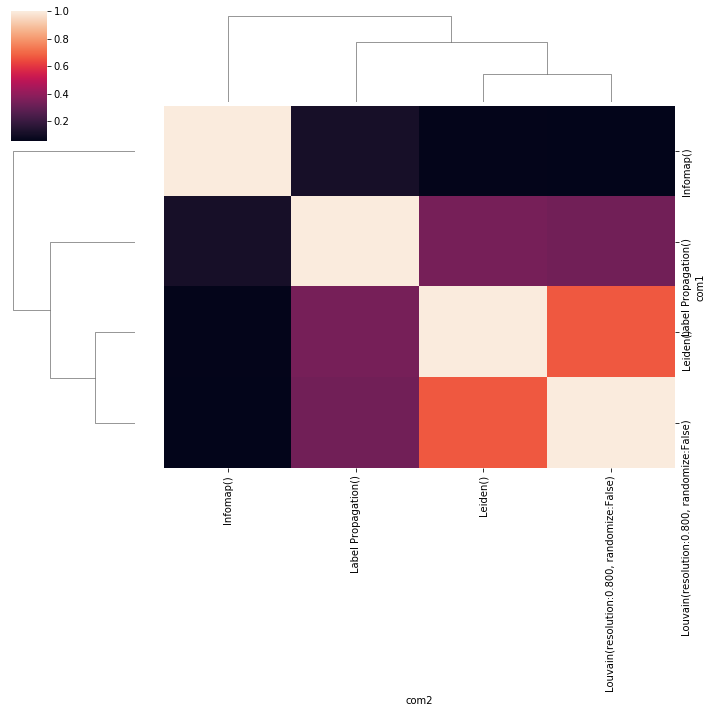

In [171]:
from cdlib import algorithms, viz, evaluation

clustermap = viz.plot_sim_matrix([leiden_coms,louv_coms, lp_coms,info_coms],evaluation.adjusted_mutual_information)

plt.show()


#### F1 score between Leiden and Louvain 

In [50]:
# Computing the NF1 scores and statistics

print(evaluation.f1(louv_coms,leiden_coms))


MatchingResult(score=0.6362857142857142, std=0.3508120026801959)


<a id="best"></a>
### Comparison  the   clustering methods ([to top](#top))

#### plot scores evaluation

In [184]:
labels=['size','degree','density','conductance','ER modularity','NG modularity','conductance','Z modularity']
labels1=['size','degree','density','conductance','ER modularity','Newman Girvan Modularity','Conductance','Z modularity']
labels2=['Leiden','Louvain','Label Propag.', 'Demon','Infomap']
size=[len(leiden_clusters),len(louv_clusters),len(lp_clusters),len(demon_clusters),len(info_clusters)]
degree=[leiden_fit[2],louv_fit[2],lp_fit[2],demon_fit[2],info_fit[2]]
density=[leiden_den[2],louv_den[2],lp_den[2],demon_den[2],demon_den[2]]
conductance=[leiden_cond[2],louv_cond[2],lp_cond[2],demon_cond[2],info_cond[2]] 
mod_den=[leiden_mod3[2],louv_mod3[2],lp_mod3[2],demon_mod3[2],info_mod3[2]]
mod_ER=[leiden_mod1[2],louv_mod1[2],lp_mod1[2],demon_mod1[2],info_mod1[2]]
mod_NG=[leiden_mod2[2],louv_mod2[2],lp_mod2[2],demon_mod2[2],info_mod2[2]]
mod_Z=[leiden_mod4[2],louv_mod4[2],lp_mod4[2],demon_mod4[2],info_mod4[2]]
mod_den=[leiden_mod3[2],louv_mod3[2],lp_mod3[2],demon_mod3[2],info_mod3[2]]


data_final=pd.DataFrame(index=labels2)

#data_final['method']=labels2
data_final['size']=size
data_final['degree']=degree
data_final['density']=density
data_final['conductance']=conductance
data_final['ER modularity']=mod_ER
data_final['NG modularity']=mod_NG
data_final['Z modularity']=mod_Z
data_final['density modularity']=mod_den


data_final.head()


,size,degree,density,conductance,ER modularity,NG modularity,Z modularity,density modularity
Leiden,40,3.012848,74.879912,0.617608,-0.015323,0.034844,0.331267,241.027841
Louvain,35,3.148992,38.574715,0.694366,-0.009432,0.034430,0.360753,220.429467
Label Propag.,581,1.431483,278.601002,0.532615,-0.201952,0.022080,0.104875,1663.382859
Demon,3941,6.878534,187.222559,0.980461,0.629015,0.001684,-0.420524,54216.602090
Infomap,4,3.934055,187.222559,0.282415,-0.469823,-6.789768,0.015180,31.472442


#### Plot Final Scores

FINAL SCORES


numpy.ndarray

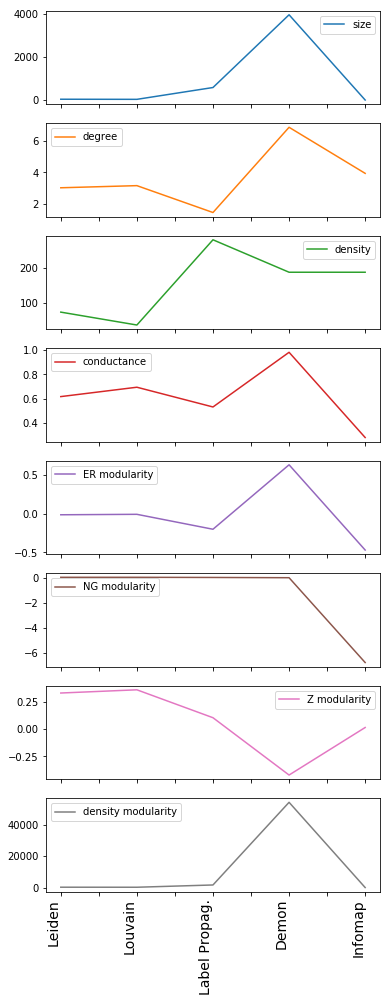

In [185]:
print('FINAL SCORES')
axes = data_final.plot.line(subplots=True, figsize=(6, 18))
plt.tick_params(axis='x', which='major', labelsize=14,rotation=90)
type(axes)


All Final Scores


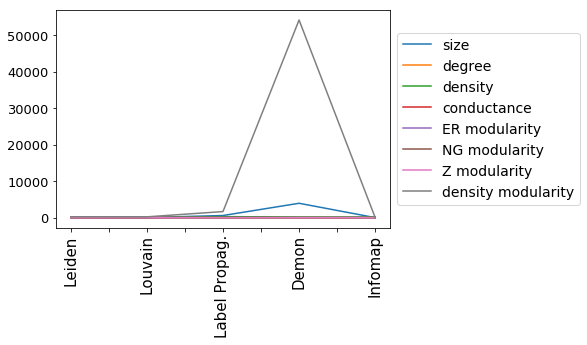

In [186]:
# Pandas
print('All Final Scores')
data_final.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.tick_params(axis='x', which='major', labelsize=15, rotation=90)
plt.tick_params(axis='y', which='major', labelsize=13)

<a id="up"></a>
### Upload Best communities ([to top](#top))

In [253]:
from cdlib import algorithms, readwrite
readwrite.write_community_csv(leiden_coms, "leiden_coms.csv", ",")

readwrite.write_community_csv(demon_coms, "demon_coms.csv", ",")

In [254]:
 data_final.to_csv("data_final.csv")

<a id='fig'></a>
## Additional Figures and Tables ([to top](#fig))


### Normalized  final scores of more important internal  fictness functions

We normalize the scores of more important  "fitness functions" such as size, degree, density,conductance, and Modularity density to have a simplified picture of how the values ​​change depending on the method used.<br>
we then create a new dataframe " d_final" with only these normalized values
end we plot the normalized scores in a graph.<br>





In [255]:
#We build the new dataframe "d_final"
d_final=[]
d_final = data_final[['size','degree','density','conductance','density modularity']]
d_final.head()

,size,degree,density,conductance,density modularity
Leiden,40,3.012848,74.879912,0.617608,241.027841
Louvain,35,3.148992,38.574715,0.694366,220.429467
Label Propag.,581,1.431483,278.601002,0.532615,1663.382859
Demon,3941,6.878534,187.222559,0.980461,54216.602090
Infomap,4,3.934055,187.222559,0.282415,31.472442


In [256]:
#Normalizze dataframe
for column in d_final:
    d_final[column]=d_final[column]/max(d_final[column])



#### New DataFrame "d_final" Normalizzed

In [257]:
d_final.head()


,size,degree,density,conductance,density modularity
Leiden,0.010150,0.438007,0.268771,0.629916,0.004446
Louvain,0.008881,0.457800,0.138459,0.708204,0.004066
Label Propag.,0.147425,0.208109,1.000000,0.543230,0.030680
Demon,1.000000,1.000000,0.672010,1.000000,1.000000
Infomap,0.001015,0.571932,0.672010,0.288043,0.000580


#### Figure of  "d_final" dataframe

Normalized final scores


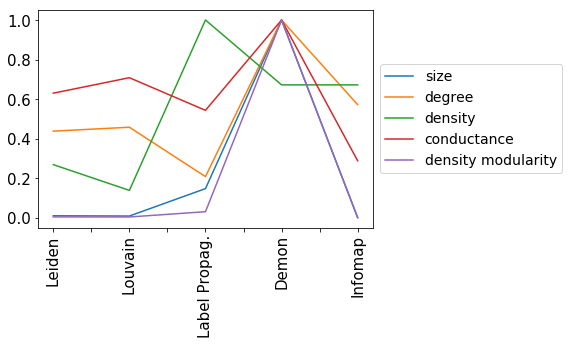

In [258]:
print('Normalized final scores')
d_final.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.tick_params(axis='x', which='major', labelsize=15, rotation=90)
plt.tick_params(axis='y', which='major', labelsize=15)

### Let's compare the different types of modularity with each other
In this case we normalize only the modularities such as Modularity" and "Density Modularity" whose values ​​do not fall within the ranges of -1 and 1.<br> We thus maintain the negative or positive sign of the modularity, dividing the values ​​by the maximum absolute value


In [259]:
#We build the new dataframe "modularities"
modu=[]
modu= data_final[['ER modularity','NG modularity','Z modularity','density modularity']]
modu.head()

,ER modularity,NG modularity,Z modularity,density modularity
Leiden,-0.015323,0.034844,0.331267,241.027841
Louvain,-0.009432,0.034430,0.360753,220.429467
Label Propag.,-0.201952,0.022080,0.104875,1663.382859
Demon,0.629015,0.001684,-0.420524,54216.602090
Infomap,-0.469823,-6.789768,0.015180,31.472442


In [260]:
#Normalizze dataframe
for column in modu:
    modu[column]=modu[column]/max(abs(modu[column]))



#### DataFrame "modu" Normalizzed

In [261]:
modu.head()

,ER modularity,NG modularity,Z modularity,density modularity
Leiden,-0.024361,0.005132,0.787748,0.004446
Louvain,-0.014994,0.005071,0.857865,0.004066
Label Propag.,-0.321061,0.003252,0.249390,0.030680
Demon,1.000000,0.000248,-1.000000,1.000000
Infomap,-0.746918,-1.000000,0.036098,0.000580


Normalized final scores of different types of modularity 


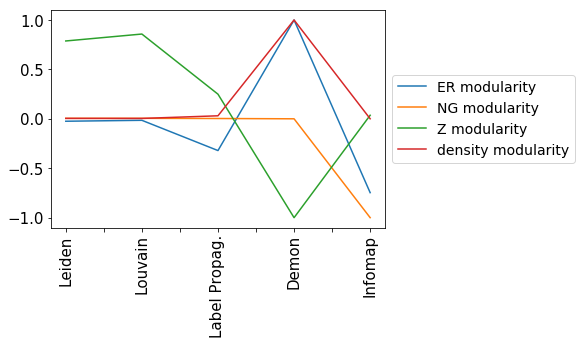

In [262]:
print('Normalized final scores of different types of modularity ')
modu.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.tick_params(axis='x', which='major', labelsize=15, rotation=90)
plt.tick_params(axis='y', which='major', labelsize=15)

### Summary table of size, conductance, scale density, Internal degree communities .
Minimun,Maximum,Avergae Scores and Deviation Standart of of Discovery community  with different types of clustering methods

In [263]:
labels1=[]
labels2=[]
labels1=['Internal Degree','Scale Density','Conductance']
labels2=['Leiden','Louvain','Label Propag.','Demon', 'Infomap']

tab1=[]
score=[]
mx=[]
mi=[]
dev=[]

score=[leiden_fit[2],louv_fit[2],lp_fit[2],demon_fit[2],info_fit[2]]
mx=[leiden_fit[1],louv_fit[1],lp_fit[2],demon_fit[1],info_fit[1]]
mi=[leiden_fit[0],louv_fit[0],lp_fit[0],demon_fit[0],info_fit[0]]
dev=[leiden_fit[3],louv_fit[3],lp_fit[3],demon_fit[3],info_fit[3]]

tab1=pd.DataFrame(index=labels2)

#data_final['method']=labels2
tab1['Score']=score
tab1['Max']=mx
tab1['Min']=mi
tab1['dev.std']=dev
print('\n Avereges Internal Degree of Communities')

tab1.head()



 Avereges Internal Degree of Communities


,Score,Max,Min,dev.std
Leiden,3.012848,8.121065,1.00000,1.552311
Louvain,3.148992,8.028144,1.50000,1.540467
Label Propag.,1.431483,1.431483,1.00000,0.670039
Demon,6.878534,35.620619,2.50000,4.693263
Infomap,3.934055,8.512006,2.38835,2.643171


In [264]:
tab1=[]
score=[]
mx=[]
mi=[]
dev=[]

score=[leiden_den[2],louv_den[2],lp_den[2],demon_fit[2],info_fit[2]]
mx=[leiden_fit[1],louv_fit[1],lp_fit[2],demon_fit[1],info_fit[1]]
mi=[leiden_fit[0],louv_fit[0],lp_fit[0],demon_fit[0],info_fit[0]]
dev=[leiden_fit[3],louv_fit[3],lp_fit[3],demon_fit[3],info_fit[3]]

tab1=pd.DataFrame(index=labels2)

#data_final['method']=labels2
tab1['Score']=score
tab1['Max']=mx
tab1['Min']=mi
tab1['dev.std']=dev
print('\n Averages Density of the communities')

tab1.head()


 Averages Density of the communities


,Score,Max,Min,dev.std
Leiden,74.879912,8.121065,1.00000,1.552311
Louvain,38.574715,8.028144,1.50000,1.540467
Label Propag.,278.601002,1.431483,1.00000,0.670039
Demon,6.878534,35.620619,2.50000,4.693263
Infomap,3.934055,8.512006,2.38835,2.643171


In [265]:
tab1=[]
score=[]
mx=[]
mi=[]
dev=[]

score=[leiden_cond[2],louv_cond[2],lp_cond[2],demon_cond[2],info_cond[2]]
mx=[leiden_cond[1],louv_cond[1],lp_cond[2],demon_cond[1],info_cond[1]]
mi=[leiden_cond[0],louv_cond[0],lp_cond[0],demon_cond[0],info_cond[0]]
dev=[leiden_cond[3],louv_cond[3],lp_cond[3],demon_cond[3],info_cond[3]]

tab1=pd.DataFrame(index=labels2)

#data_final['method']=labels2
tab1['Score']=score
tab1['Max']=mx
tab1['Min']=mi
tab1['dev.std']=dev
print('\n Averges Conductance of Communities')

tab1.head()


 Averges Conductance of Communities


,Score,Max,Min,dev.std
Leiden,0.617608,0.873016,0.102041,0.210402
Louvain,0.694366,0.896601,0.102041,0.209305
Label Propag.,0.532615,0.532615,0.063830,0.192456
Demon,0.980461,0.999357,0.285714,0.040377
Infomap,0.282415,0.714129,0.027668,0.262040
